In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import imread
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
from keras.preprocessing import image
from keras.backend.tensorflow_backend import set_session
from ssd import SSD300
from keras.applications.imagenet_utils import preprocess_input
from ssd_utils import BBoxUtility
import matplotlib.pyplot as plt
from SSD_tester import calc_detection_prec_rec, calc_detection_ap

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        allow_growth=True 
    )
)
sess = sess = tf.Session(config=config)



Using TensorFlow backend.


In [2]:
NYU_CLASSES = ['bathtub', 'bed', 'bookshelf', 'box', 'chair', 'counter', 'desk', 'door', 'dresser',
               'garbage_bin', 'lamp', 'monitor', 'night_stand', 'pillow', 'sink', 'sofa', 'table', 'tv', 'toilet']
NUM_CLASSES = len(NYU_CLASSES) + 1
input_shape = (300, 300, 3) #channel last

In [3]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('/data/jun/checkpoints/SUNRGBD/v3/weights-v3.151-2.37.hdf5')

(64,)


In [4]:
gt = pickle.load(open('../pkls/SUNRGBD/RGB_v8.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
num_val = int(round((len(keys) - num_train)/2))
val_keys = keys[num_train:]
val_keys = val_keys[:num_val]
test_keys = keys[(num_train + num_val):] 


In [5]:
path_prefix = '/data/jun/dataset/'
inputs = []
images = []
# img_path = path_prefix + sorted(val_keys )[100]
# img = image.load_img(img_path, target_size=(300, 300))
# img = image.img_to_array(img)
# images.append(imread(img_path))
# inputs.append(img.copy())
# inputs = preprocess_input(np.array(inputs))

for key in val_keys:
    img_path = path_prefix + key
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))


/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


In [6]:
priors = pickle.load(open('../pkls/prior_boxes_ssd300.pkl', 'rb'))
preds = model.predict(inputs, batch_size=16, verbose=1)


966/966 [==============================] - 33s    


In [15]:
bbox_util = BBoxUtility(NUM_CLASSES, priors, nms_thresh=1.0)

In [16]:
results = bbox_util.detection_out(preds,  confidence_threshold=0)

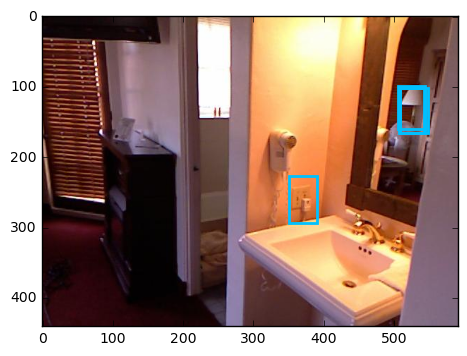

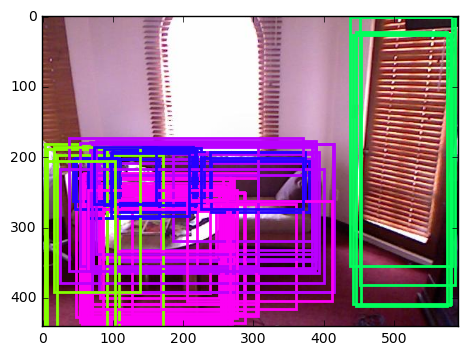

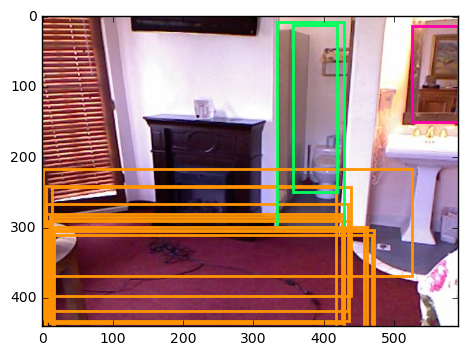

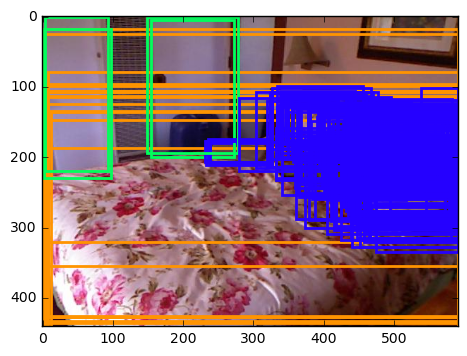

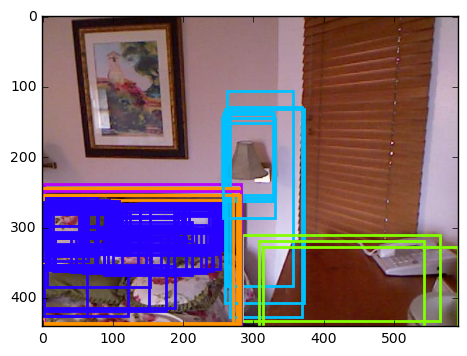

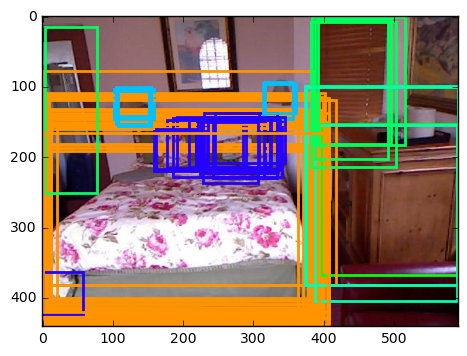

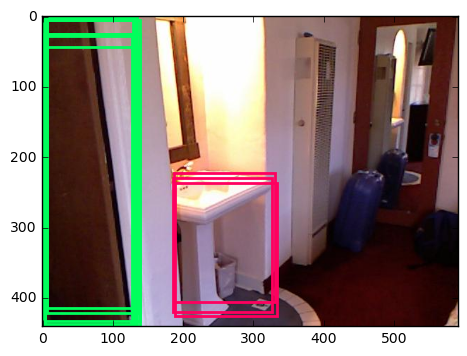

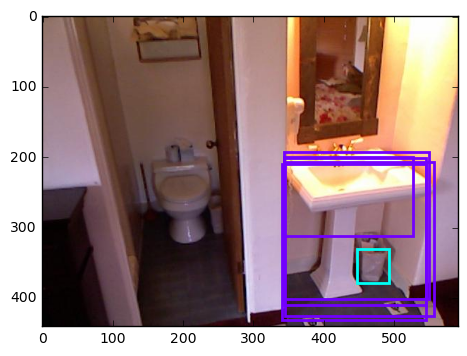

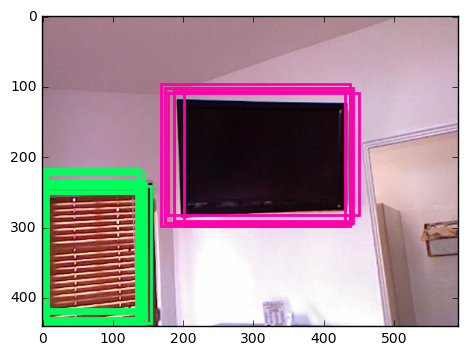

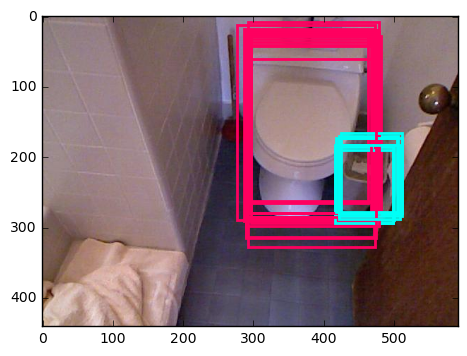

In [17]:
for i, img in enumerate(images[0:10]):
    if len(results[i]) == 0:
        continue
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()


    for i in range(top_conf.shape[0]):
            
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]

        label = int(top_label_indices[i])
        label_name = NYU_CLASSES[label - 1]
#        display_txt = '{:0.2f}, {}'.format(score, label_name)
        display_txt = ''
        coords = (xmin, ymin), xmax-xmin, ymax-ymin
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    plt.show()
    plt.imsave('./images/before_nms_'+ str(i) +'.png', img)